# Fast Fourier Transform (FFT)

In [1]:
import sys
sys.path.append('../..')

In [2]:
import PIL.Image
import numpy as np
import matplotlib.pyplot as plt

import libtools

---

### DATA

In [3]:
img = np.array(PIL.Image.open("../../data/images/coco/mesh.png").convert('L'), dtype=float)
img /= np.max(img)

print('Image:', img.shape)
print('min:', f"{img.min():.2f}", 'max:', f"{img.max():.2f}")

Image: (200, 200)
min: 0.00 max: 1.00


---

### COMPUTE FFT

In [4]:
f = np.fft.fft2(img) # Frequency transform
fshift = np.fft.fftshift(f) # Shift zero frequency component (DC-component)
power = np.abs(fshift) # Process complex numbers
phase = np.angle(fshift)

In [5]:
# Define radial distance
nx, ny = power.shape
x = np.arange(-power.shape[0]//2, power.shape[0]//2)
y = np.arange(-power.shape[1]//2, power.shape[1]//2)
X, Y = np.meshgrid(x, y)
dist = np.sqrt(X**2 + Y**2)

# Compute spatial frequency
hist, bins = np.histogram(dist.flatten(), bins=np.arange(dist.max()), weights=power.flatten())

count = hist[1:].argmax()
print('Maximum spatial frequency:', count)

Maximum spatial frequency: 14


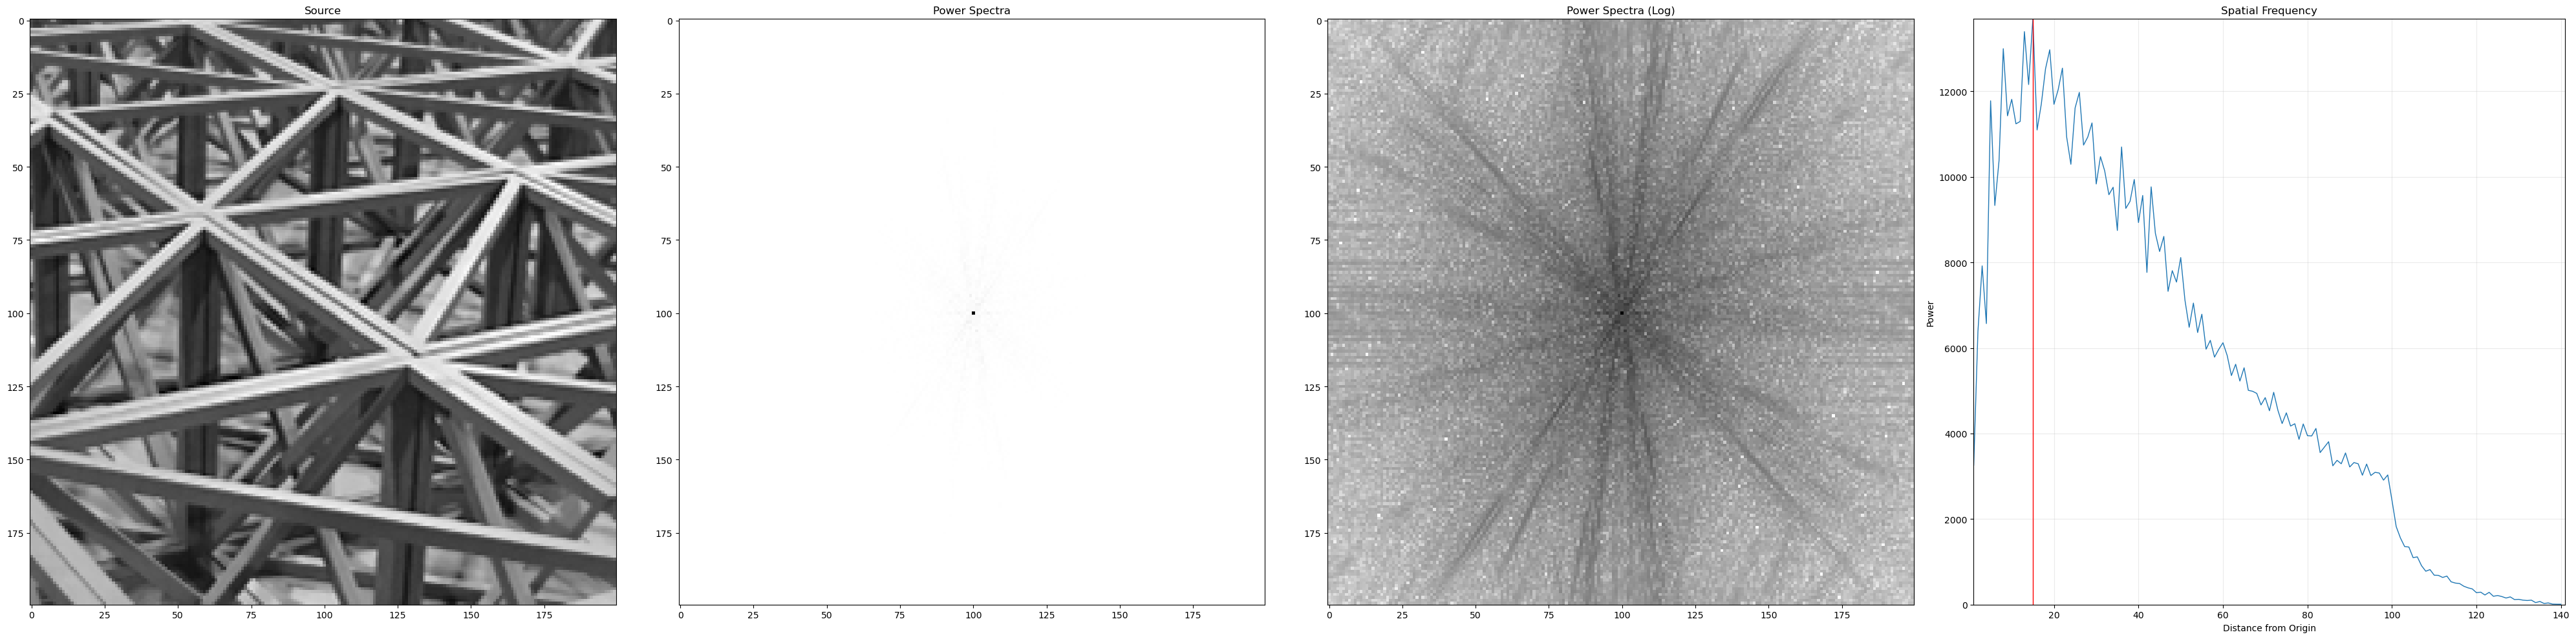

In [6]:
plt.figure(figsize=(40,10))
plt.subplot(1,4,1)
plt.imshow(img, 'gray')
plt.title('Source')

plt.subplot(1,4,2)
plt.imshow(power, 'binary')
plt.title('Power Spectra')

plt.subplot(1,4,3)
plt.imshow(np.log(power), 'binary')
plt.title('Power Spectra (Log)')

plt.subplot(1,4,4)
plt.plot(bins[:-1], hist, lw=1)
plt.vlines(count+1, 0, hist[1:].max(), linewidth=1, color='r')
plt.title('Spatial Frequency')
plt.xlabel('Distance from Origin'), plt.ylabel('Power')
plt.xlim([1,int(dist.max())]), plt.ylim([0,int(hist[1:].max())])
plt.grid(alpha=0.25)

plt.tight_layout()

---

### CONVOLVE

In [7]:
src = np.load('../../data/mat/SOM_orient_v1.npy')

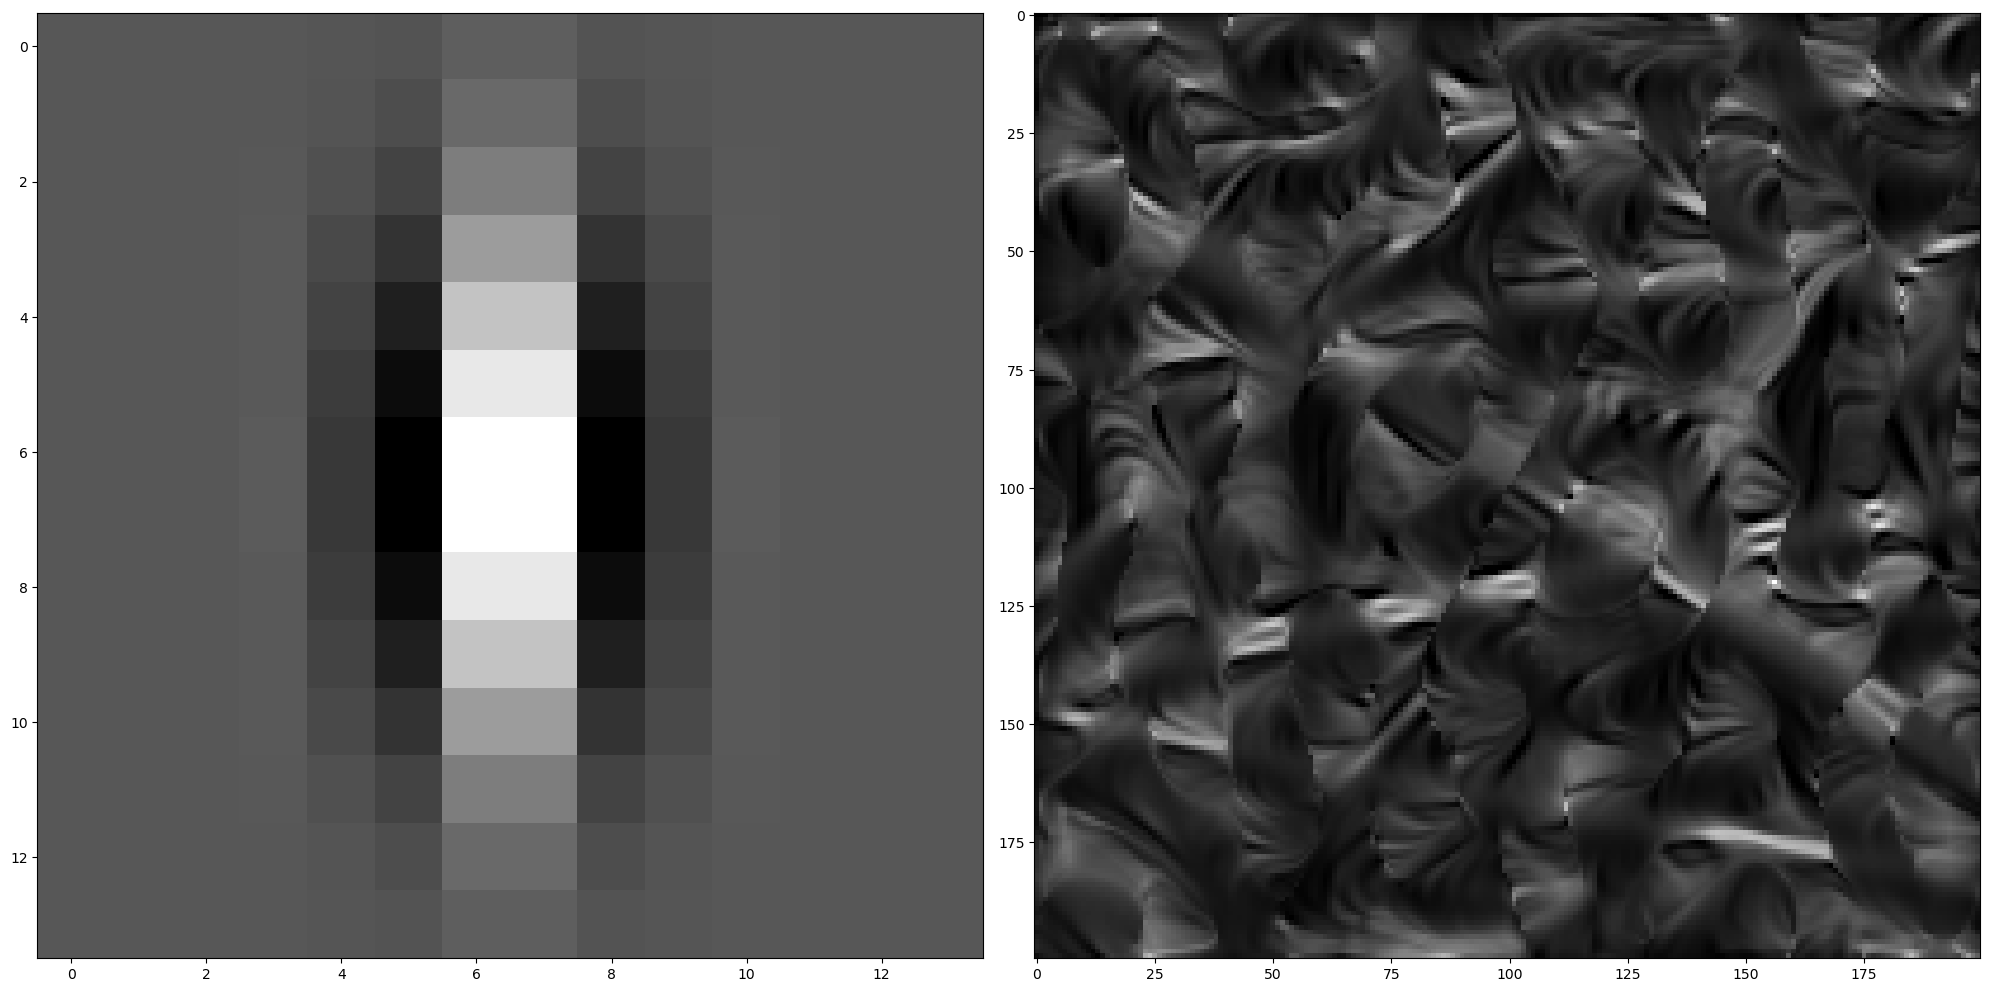

In [8]:
k_factor = 1
features = libtools.gabor_conv(img, src, step=int(count*k_factor))
features /= np.max(features)

plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
plt.imshow(libtools.gabor_filter(1,2,0, samples=int(count*k_factor)), 'gray')

plt.subplot(1,2,2)
plt.imshow(features, 'gray')
plt.tight_layout()

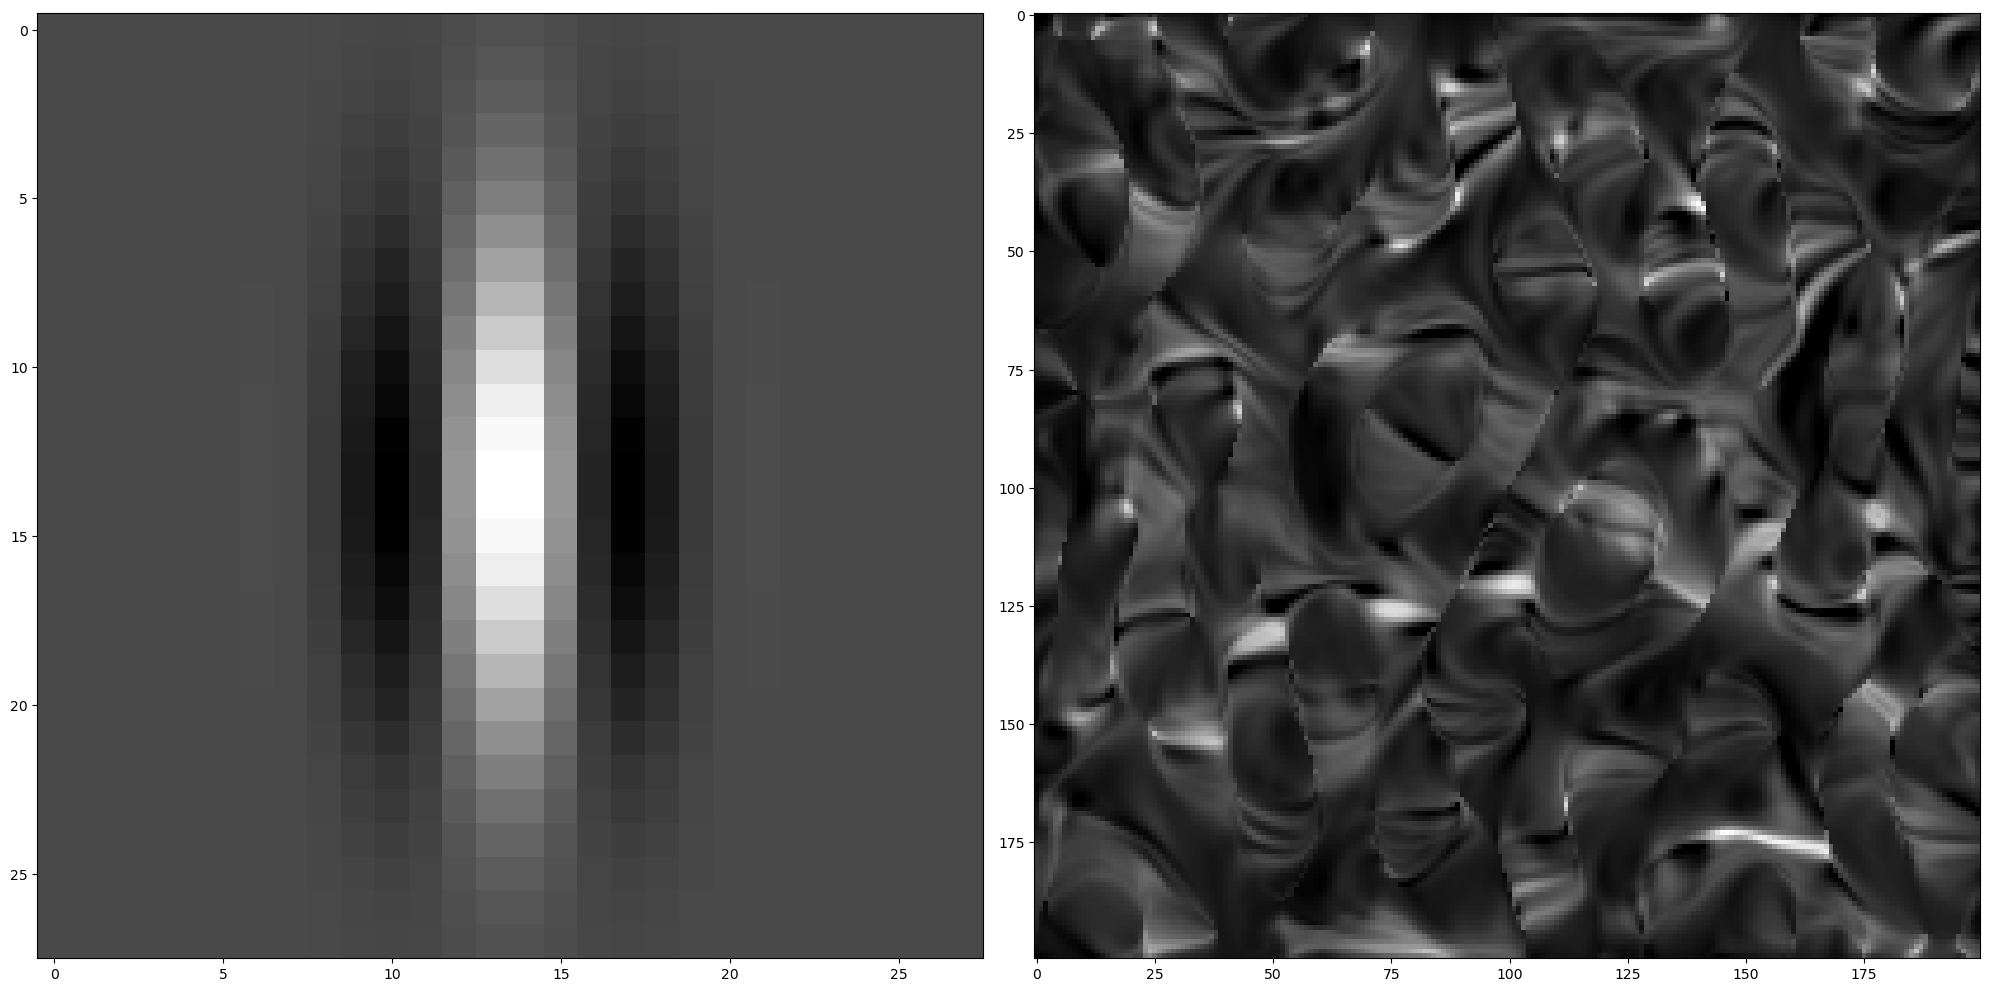

In [9]:
k_factor = 2
features = libtools.gabor_conv(img, src, step=int(count*k_factor))
features /= np.max(features)

plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
plt.imshow(libtools.gabor_filter(1,2,0, samples=int(count*k_factor)), 'gray')

plt.subplot(1,2,2)
plt.imshow(features, 'gray')
plt.tight_layout()

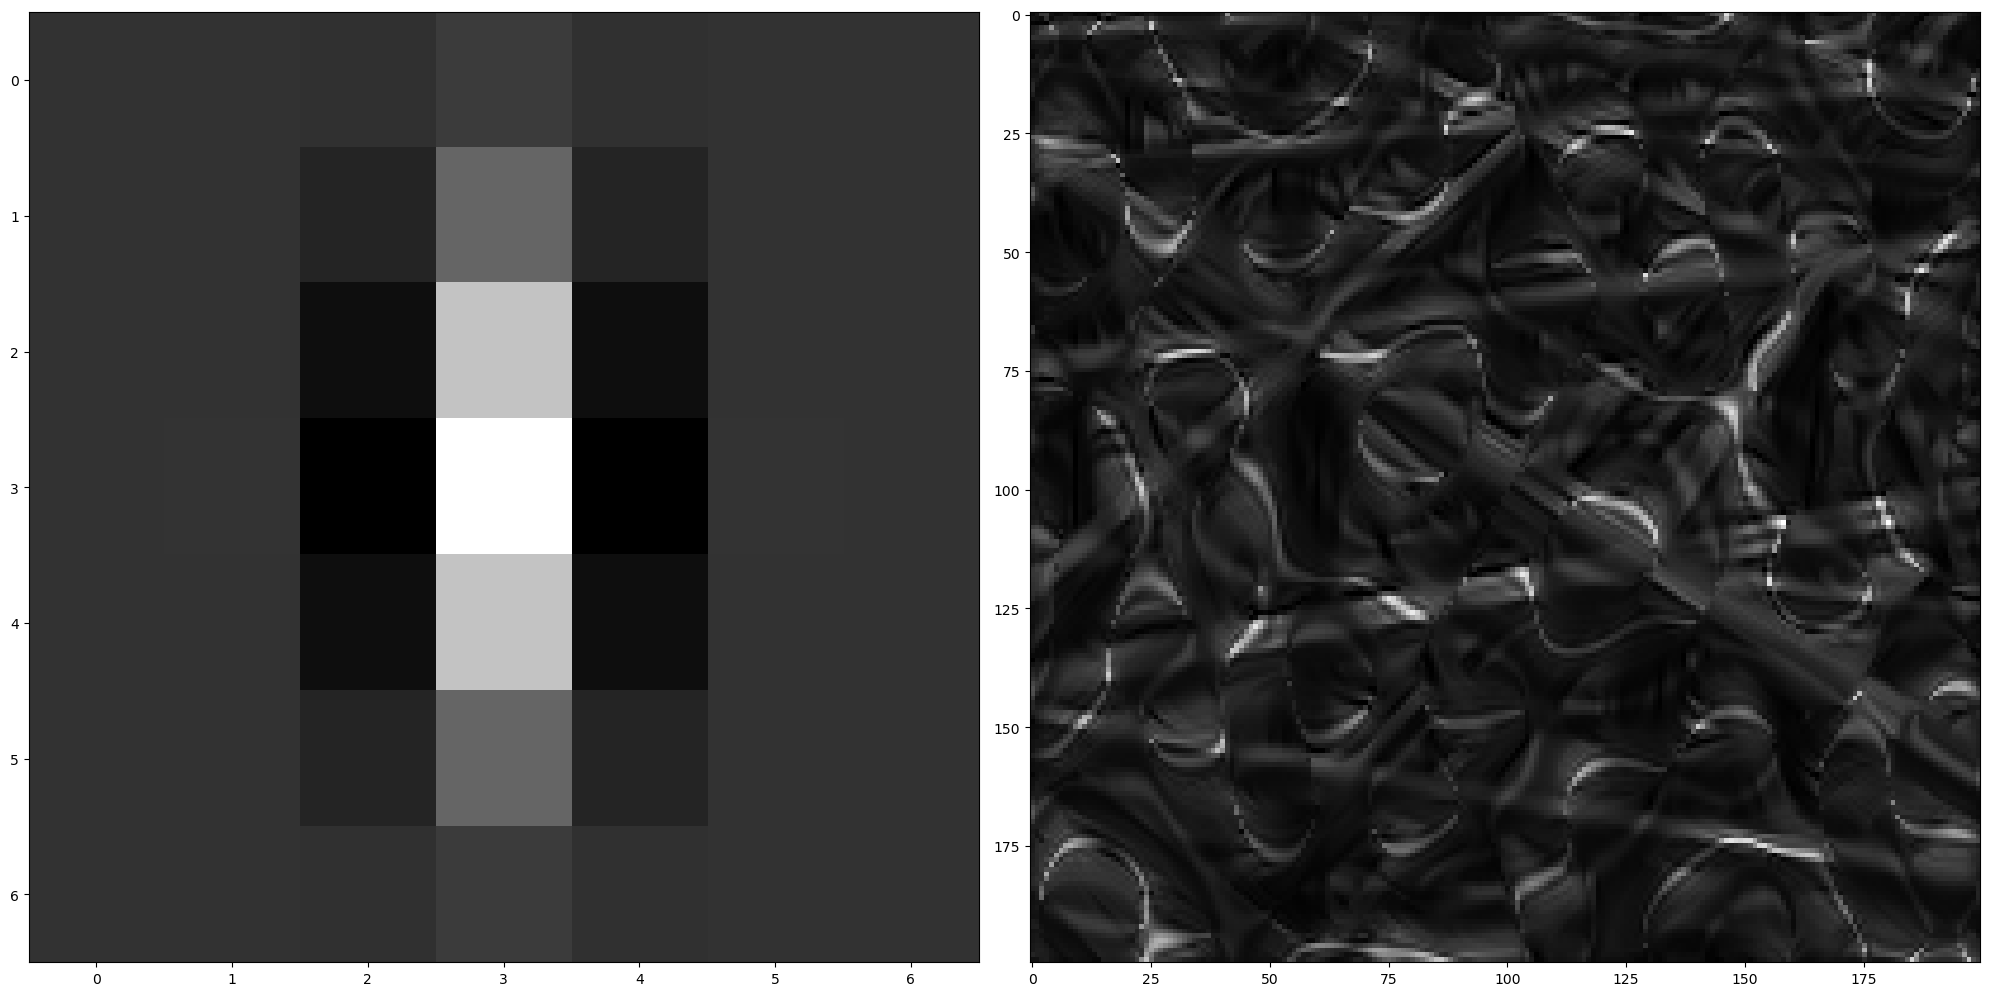

In [10]:
k_factor = 0.5
features = libtools.gabor_conv(img, src, step=int(count*k_factor))
features /= np.max(features)

plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
plt.imshow(libtools.gabor_filter(1,2,0, samples=int(count*k_factor)), 'gray')

plt.subplot(1,2,2)
plt.imshow(features, 'gray')
plt.tight_layout()

---

### RECONSTRUCT IMAGE

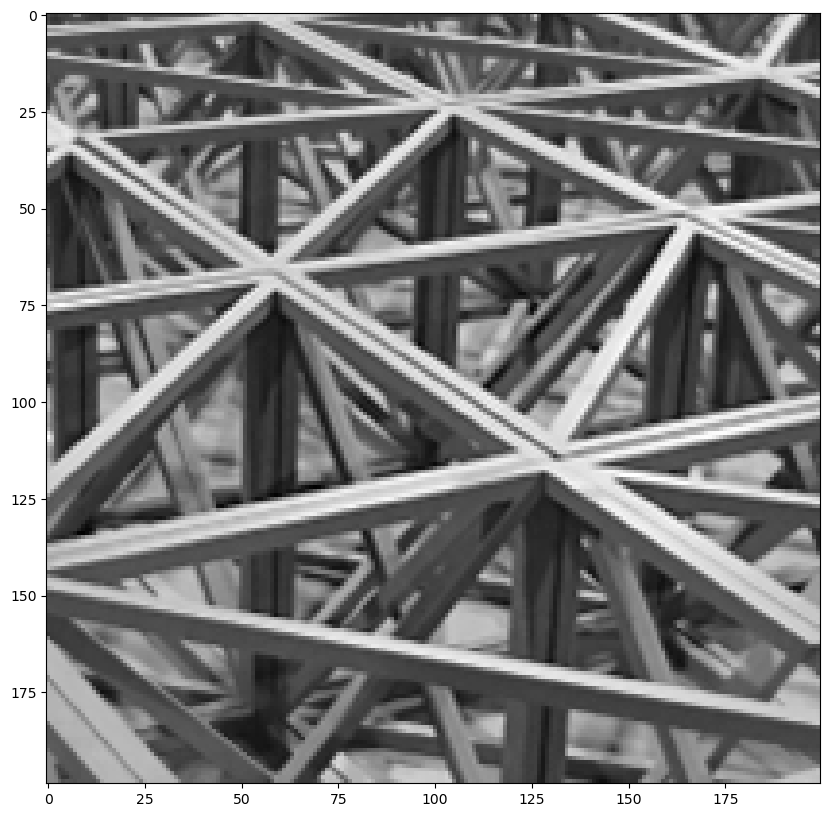

In [11]:
f_ishift = np.fft.ifftshift(fshift) # Inverse shift of DC component
hpf = np.abs(np.fft.ifft2(f_ishift)) # High-Pass Filter

fshift_recon = power * np.exp(1j * phase) # Reconstruct the fourier coefficients using the magnitude and phase | j = imaginary part
f_recon = np.fft.ifftshift(fshift_recon) # Shift the fourier coefficients back to the original positions
img_recon = np.fft.ifft2(f_recon) # Inverse FFT
img_recon = np.abs(img_recon) # Ignore any imaginary components

plt.figure(figsize=(10,10))
plt.imshow(hpf[:-1], 'gray')